# Importing Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None)


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Dense
from tensorflow.keras.layers import Dense, LSTM, Bidirectional


# Importing the Dataset



- Predictive maintenance on NASA's turbofan engine degradation dataset (CMAPSS). 
- Datasets include simulations of multiple turbofan engines over time, each row contains the following information:
  1. Engine unit number
  2. Time, in cycles
  3. Three operational settings
  4. 21 sensor readings.




In [2]:

# Define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['Mach Number', 'Altitude', 'Sea-level temperature']
sensor_names = [
    "Fan inlet temperature (◦R)",
    "LPC outlet temperature (◦R)",
    "HPC outlet temperature (◦R)",
    "LPT outlet temperature (◦R)",
    "Fan inlet Pressure (psia)",
    "bypass-duct pressure (psia)",
    "HPC outlet pressure (psia)",
    "Physical fan speed (rpm)",
    "Physical core speed (rpm)",
    "Engine pressure ratio (P50/P2)",
    "HPC outlet Static pressure (psia)",
    "Ratio of fuel flow to Ps30 (pps/psia)",
    "Corrected fan speed (rpm)",
    "Corrected core speed (rpm)",
    "Bypass Ratio",
    "Burner fuel-air ratio",
    "Bleed Enthalpy",
    "Required fan speed",
    "Required fan conversion speed",
    "High-pressure turbines Cool air flow",
    "Low-pressure turbines Cool air flow"
]

col_names = index_names + setting_names + sensor_names

# Read data
train = pd.read_csv('train_FD002.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD002.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD002.txt', sep='\s+', header=None, names=['RUL'])

# Train data contains all features (Unit Number + setting parameters & sensor parameters)
# Test data contains all features (Unit Number + setting parameters & sensor parameters)
# Y_test contains RUL for the test data.
train.head()


unit_nr  time_cycles  Mach Number  Altitude  Sea-level temperature  \
0        1            1      34.9983    0.8400                  100.0   
1        1            2      41.9982    0.8408                  100.0   
2        1            3      24.9988    0.6218                   60.0   
3        1            4      42.0077    0.8416                  100.0   
4        1            5      25.0005    0.6203                   60.0   

   Fan inlet temperature (◦R)  LPC outlet temperature (◦R)  \
0                      449.44                       555.32   
1                      445.00                       549.90   
2                      462.54                       537.31   
3                      445.00                       549.51   
4                      462.54                       537.07   

   HPC outlet temperature (◦R)  LPT outlet temperature (◦R)  \
0                      1358.61                      1137.23   
1                      1353.22                      1125.78   
2                      1256.76                      1047.45   
3                      1354.03                      1126.38   
4                      1257.71                      1047.93   

   Fan inlet Pressure (psia)  ...  Ratio of fuel flow to Ps30 (pps/psia)  \
0                       5.48  ...                                 183.06   
1                       3.91  ...                                 130.42   
2                       7.05  ...                                 164.22   
3                       3.91  ...                                 130.72   
4                       7.05  ...                                 164.31   

   Corrected fan speed (rpm)  Corrected core speed (rpm)  Bypass Ratio  \
0                    2387.72                     8048.56        9.3461   
1                    2387.66                     8072.30        9.3774   
2                    2028.03                     7864.87       10.8941   
3                    2387.61                     8068.66        9.3528   
4                    2028.00                     7861.23       10.8963   

   Burner fuel-air ratio  Bleed Enthalpy  Required fan speed  \
0                   0.02             334                2223   
1                   0.02             330                2212   
2                   0.02             309                1915   
3                   0.02             329                2212   
4                   0.02             309                1915   

   Required fan conversion speed  High-pressure turbines Cool air flow  \
0                         100.00                                 14.73   
1                         100.00                                 10.41   
2                          84.93                                 14.08   
3                         100.00                                 10.59   
4                          84.93                                 14.13   

   Low-pressure turbines Cool air flow  
0                               8.8071  
1                               6.2665  
2                               8.6723  
3                               6.4701  
4                               8.5286  

[5 rows x 26 columns]

In [3]:
test.head()

unit_nr  time_cycles  Mach Number  Altitude  Sea-level temperature  \
0        1            1       9.9987    0.2502                  100.0   
1        1            2      20.0026    0.7000                  100.0   
2        1            3      35.0045    0.8400                  100.0   
3        1            4      42.0066    0.8410                  100.0   
4        1            5      24.9985    0.6213                   60.0   

   Fan inlet temperature (◦R)  LPC outlet temperature (◦R)  \
0                      489.05                       605.03   
1                      491.19                       607.82   
2                      449.44                       556.00   
3                      445.00                       550.17   
4                      462.54                       536.72   

   HPC outlet temperature (◦R)  LPT outlet temperature (◦R)  \
0                      1497.17                      1304.99   
1                      1481.20                      1246.11   
2                      1359.08                      1128.36   
3                      1349.69                      1127.89   
4                      1253.18                      1050.69   

   Fan inlet Pressure (psia)  ...  Ratio of fuel flow to Ps30 (pps/psia)  \
0                      10.52  ...                                 371.69   
1                       9.35  ...                                 315.32   
2                       5.48  ...                                 183.04   
3                       3.91  ...                                 130.40   
4                       7.05  ...                                 164.56   

   Corrected fan speed (rpm)  Corrected core speed (rpm)  Bypass Ratio  \
0                    2388.18                     8114.10        8.6476   
1                    2388.12                     8053.06        9.2405   
2                    2387.75                     8053.04        9.3472   
3                    2387.72                     8066.90        9.3961   
4                    2028.05                     7865.66       10.8682   

   Burner fuel-air ratio  Bleed Enthalpy  Required fan speed  \
0                   0.03             369                2319   
1                   0.02             364                2324   
2                   0.02             333                2223   
3                   0.02             332                2212   
4                   0.02             305                1915   

   Required fan conversion speed  High-pressure turbines Cool air flow  \
0                         100.00                                 28.42   
1                         100.00                                 24.29   
2                         100.00                                 14.98   
3                         100.00                                 10.35   
4                          84.93                                 14.31   

   Low-pressure turbines Cool air flow  
0                              17.1551  
1                              14.8039  
2                               8.9125  
3                               6.4181  
4                               8.5740  

[5 rows x 26 columns]

In [4]:
y_test.head()

RUL
0   18
1   79
2  106
3  110
4   15

In [5]:
train.shape

(53759, 26)

In [6]:
y_test.shape

(259, 1)

In [7]:
train['unit_nr'].unique()

# There are 259 no unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Note:  for Test Dataset Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
therefore the test dataset will be subsetted to represent the same.

In [8]:
test.shape

(33991, 26)

In [9]:
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same

test = test.groupby('unit_nr').last().reset_index().drop(['unit_nr','time_cycles'], axis=1)


In [10]:
y_test.shape

# RUL value for 259 no of engines.

(259, 1)

In [11]:
test.shape
# Now test data contains entries for 259 no of engines with their RUL.

(259, 24)

# Data Pre-Processing + Data Visualization

In [12]:
train.describe()

unit_nr   time_cycles   Mach Number      Altitude  \
count  53759.000000  53759.000000  53759.000000  53759.000000   
mean     131.082981    109.154746     23.998407      0.572056   
std       74.463862     69.180569     14.747376      0.310016   
min        1.000000      1.000000      0.000000      0.000000   
25%       68.000000     52.000000     10.004600      0.250700   
50%      131.000000    104.000000     25.001300      0.700000   
75%      195.000000    157.000000     41.998000      0.840000   
max      260.000000    378.000000     42.008000      0.842000   

       Sea-level temperature  Fan inlet temperature (◦R)  \
count           53759.000000                53759.000000   
mean               94.046020                  472.910207   
std                14.237735                   26.389707   
min                60.000000                  445.000000   
25%               100.000000                  445.000000   
50%               100.000000                  462.540000   
75%               100.000000                  491.190000   
max               100.000000                  518.670000   

       LPC outlet temperature (◦R)  HPC outlet temperature (◦R)  \
count                 53759.000000                 53759.000000   
mean                    579.672399                  1419.971013   
std                      37.289399                   105.946341   
min                     535.530000                  1243.730000   
25%                     549.570000                  1352.760000   
50%                     555.980000                  1369.180000   
75%                     607.340000                  1499.370000   
max                     644.520000                  1612.880000   

       LPT outlet temperature (◦R)  Fan inlet Pressure (psia)  ...  \
count                 53759.000000               53759.000000  ...   
mean                   1205.442024                   8.031986  ...   
std                     119.123428                   3.613839  ...   
min                    1023.770000                   3.910000  ...   
25%                    1123.655000                   3.910000  ...   
50%                    1138.890000                   7.050000  ...   
75%                    1306.850000                  10.520000  ...   
max                    1439.230000                  14.620000  ...   

       Ratio of fuel flow to Ps30 (pps/psia)  Corrected fan speed (rpm)  \
count                           53759.000000               53759.000000   
mean                              266.069034                2334.557253   
std                               137.659507                 128.068271   
min                               129.120000                2027.610000   
25%                               131.520000                2387.900000   
50%                               183.200000                2388.080000   
75%                               371.260000                2388.170000   
max                               523.370000                2390.480000   

       Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
count                53759.000000  53759.000000           53759.000000   
mean                  8066.597682      9.329654               0.023326   
std                     84.837950      0.749335               0.004711   
min                   7848.360000      8.335700               0.020000   
25%                   8062.140000      8.677800               0.020000   
50%                   8082.540000      9.310900               0.020000   
75%                   8127.195000      9.386900               0.030000   
max                   8268.500000     11.066900               0.030000   

       Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
count    53759.000000        53759.000000                   53759.000000   
mean       348.309511         2228.806358                      97.756838   
std         27.754515          145.327980                       5.364067   
min

In [13]:
# Adding RUL (Ramining Useful Life) to the train dataset

In [14]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

Fan inlet temperature (◦R)  LPC outlet temperature (◦R)  \
0                      449.44                       555.32   
1                      445.00                       549.90   
2                      462.54                       537.31   
3                      445.00                       549.51   
4                      462.54                       537.07   

   HPC outlet temperature (◦R)  LPT outlet temperature (◦R)  \
0                      1358.61                      1137.23   
1                      1353.22                      1125.78   
2                      1256.76                      1047.45   
3                      1354.03                      1126.38   
4                      1257.71                      1047.93   

   Fan inlet Pressure (psia)  bypass-duct pressure (psia)  \
0                       5.48                         8.00   
1                       3.91                         5.71   
2                       7.05                         9.02   
3                       3.91                         5.71   
4                       7.05                         9.03   

   HPC outlet pressure (psia)  Physical fan speed (rpm)  \
0                      194.64                   2222.65   
1                      138.51                   2211.57   
2                      175.71                   1915.11   
3                      138.46                   2211.58   
4                      175.05                   1915.10   

   Physical core speed (rpm)  Engine pressure ratio (P50/P2)  ...  \
0                    8341.91                            1.02  ...   
1                    8303.96                            1.02  ...   
2                    8001.42                            0.94  ...   
3                    8303.96                            1.02  ...   
4                    7993.23                            0.94  ...   

   Corrected fan speed (rpm)  Corrected core speed (rpm)  Bypass Ratio  \
0                    2387.72                     8048.56        9.3461   
1                    2387.66                     8072.30        9.3774   
2                    2028.03                     7864.87       10.8941   
3                    2387.61                     8068.66        9.3528   
4                    2028.00                     7861.23       10.8963   

   Burner fuel-air ratio  Bleed Enthalpy  Required fan speed  \
0                   0.02             334                2223   
1                   0.02             330                2212   
2                   0.02             309                1915   
3                   0.02             329                2212   
4                   0.02             309                1915   

   Required fan conversion speed  High-pressure turbines Cool air flow  \
0                         100.00                                 14.73   
1                         100.00                                 10.41   
2                          84.93                                 14.08   
3                         100.00                                 10.59   
4                          84.93                                 14.13   

   Low-pressure turbines Cool air flow  RUL  
0                               8.8071  148  
1                               6.2665  147  
2                               8.6723  146  
3                               6.4701  145  
4                               8.5286  144  

[5 rows x 22 columns]

In [15]:
train.head(5)

unit_nr  time_cycles  Mach Number  Altitude  Sea-level temperature  \
0        1            1      34.9983    0.8400                  100.0   
1        1            2      41.9982    0.8408                  100.0   
2        1            3      24.9988    0.6218                   60.0   
3        1            4      42.0077    0.8416                  100.0   
4        1            5      25.0005    0.6203                   60.0   

   Fan inlet temperature (◦R)  LPC outlet temperature (◦R)  \
0                      449.44                       555.32   
1                      445.00                       549.90   
2                      462.54                       537.31   
3                      445.00                       549.51   
4                      462.54                       537.07   

   HPC outlet temperature (◦R)  LPT outlet temperature (◦R)  \
0                      1358.61                      1137.23   
1                      1353.22                      1125.78   
2                      1256.76                      1047.45   
3                      1354.03                      1126.38   
4                      1257.71                      1047.93   

   Fan inlet Pressure (psia)  ...  Corrected fan speed (rpm)  \
0                       5.48  ...                    2387.72   
1                       3.91  ...                    2387.66   
2                       7.05  ...                    2028.03   
3                       3.91  ...                    2387.61   
4                       7.05  ...                    2028.00   

   Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
0                     8048.56        9.3461                   0.02   
1                     8072.30        9.3774                   0.02   
2                     7864.87       10.8941                   0.02   
3                     8068.66        9.3528                   0.02   
4                     7861.23       10.8963                   0.02   

   Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
0             334                2223                         100.00   
1             330                2212                         100.00   
2             309                1915                          84.93   
3             329                2212                         100.00   
4             309                1915                          84.93   

   High-pressure turbines Cool air flow  Low-pressure turbines Cool air flow  \
0                                 14.73                               8.8071   
1                                 10.41                               6.2665   
2                                 14.08                               8.6723   
3                                 10.59                               6.4701   
4                                 14.13                               8.5286   

   RUL  
0  148  
1  147  
2  146  
3  145  
4  144  

[5 rows x 27 columns]

## Plotting of RUL

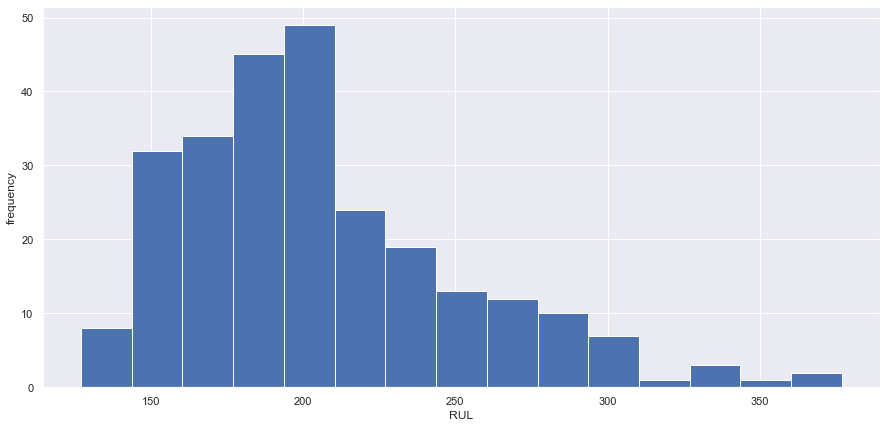

In [16]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [17]:
# We can see the RUL for engine is bit skewed on left side. This may affect perfomance of the model however as of now we will keep it as it.


## Plotting of Sensor Values Vs RUL

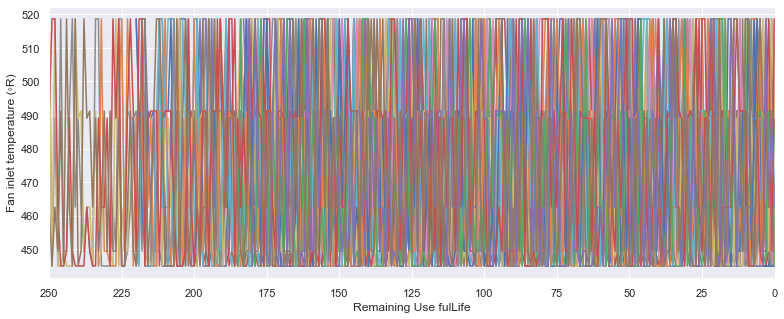

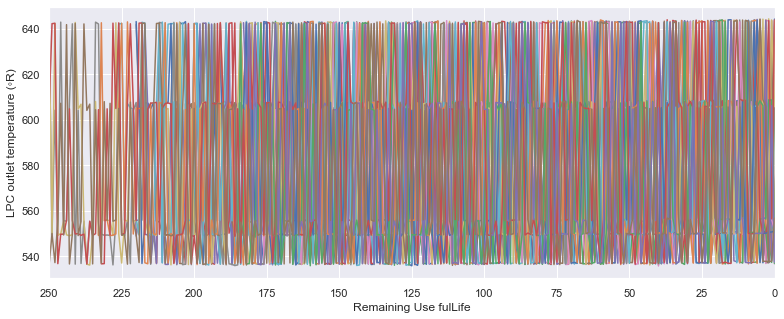

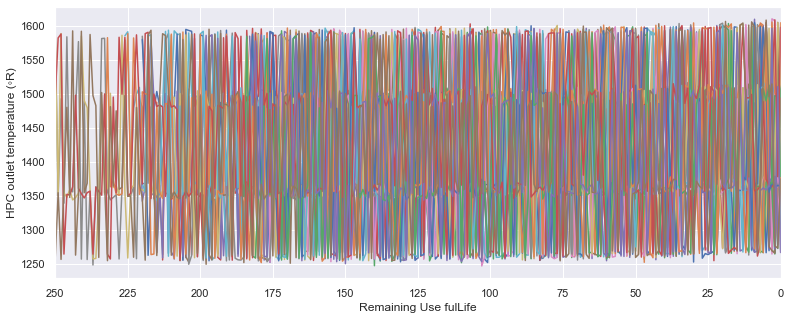

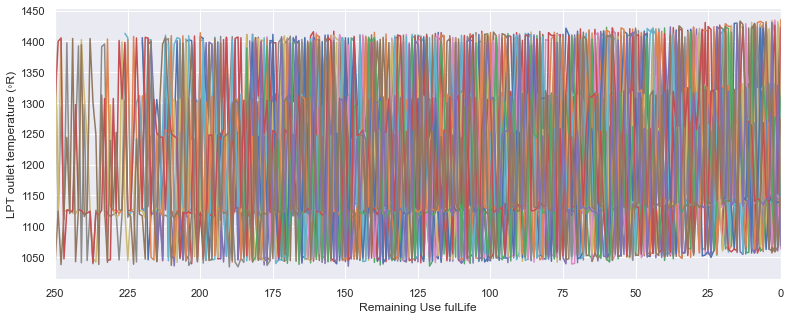

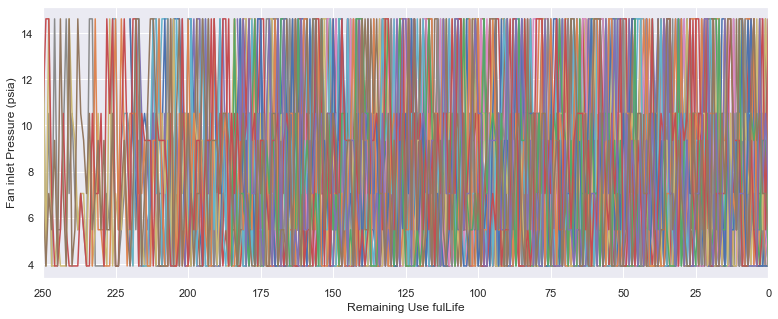

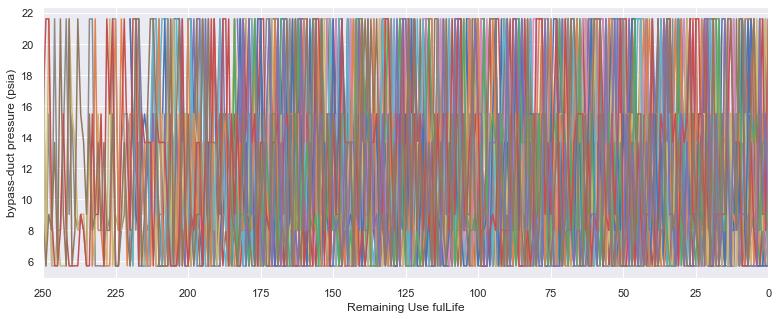

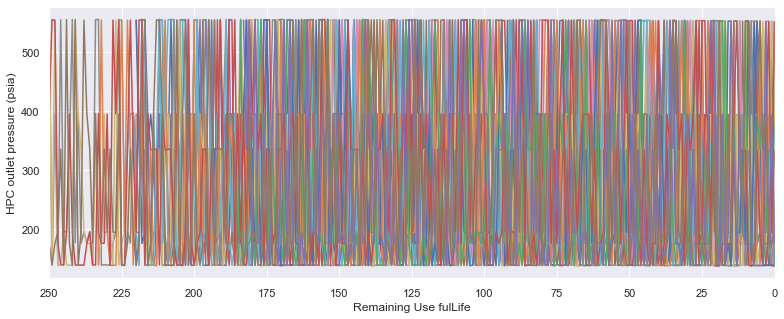

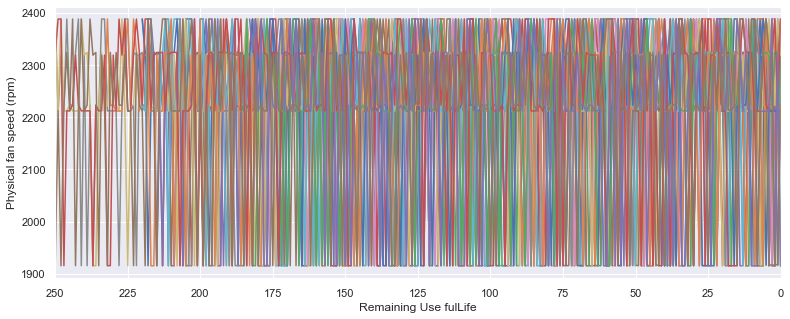

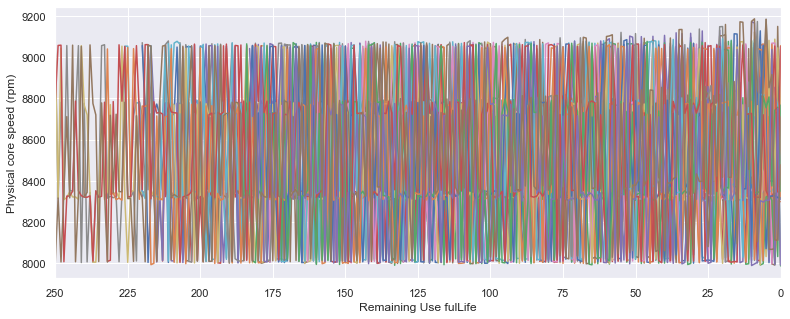

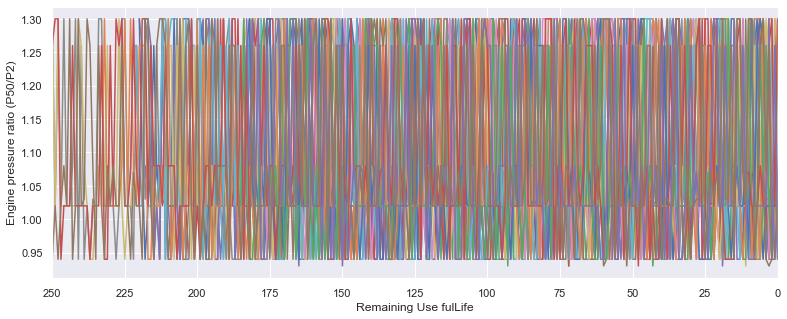

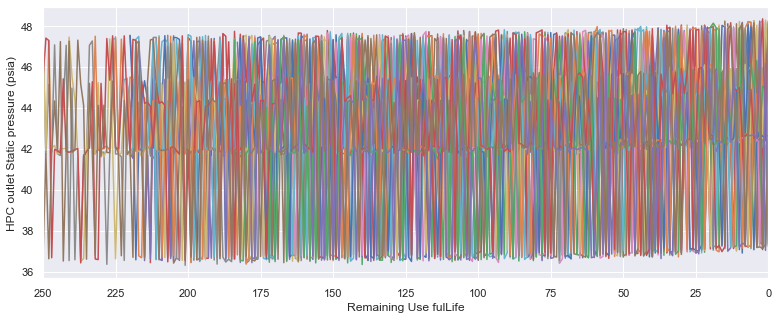

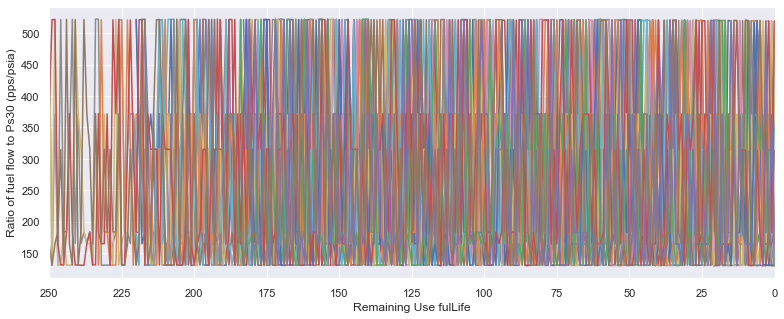

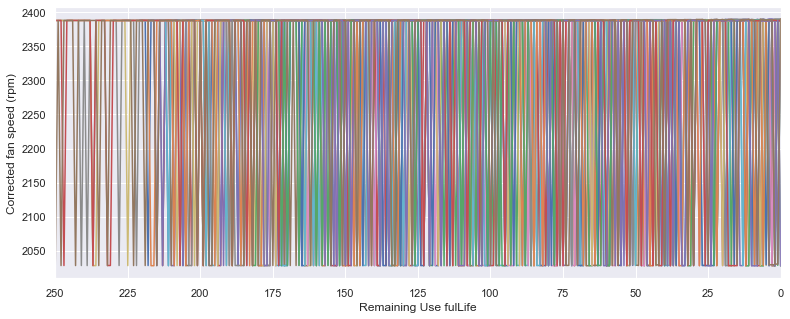

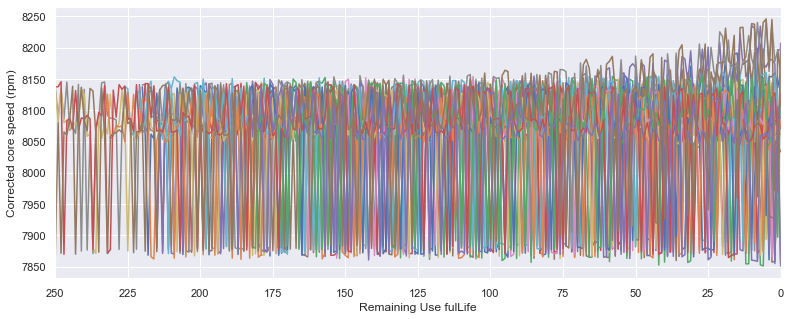

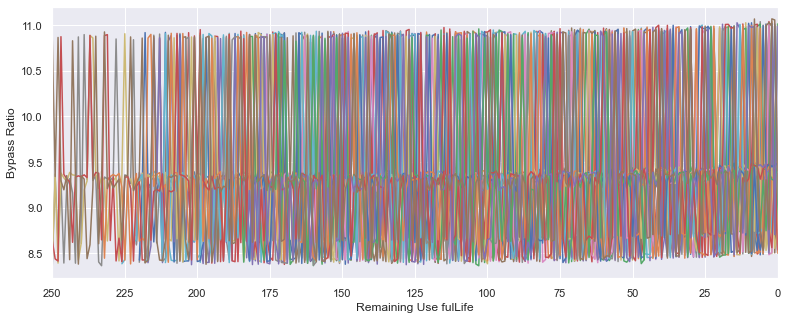

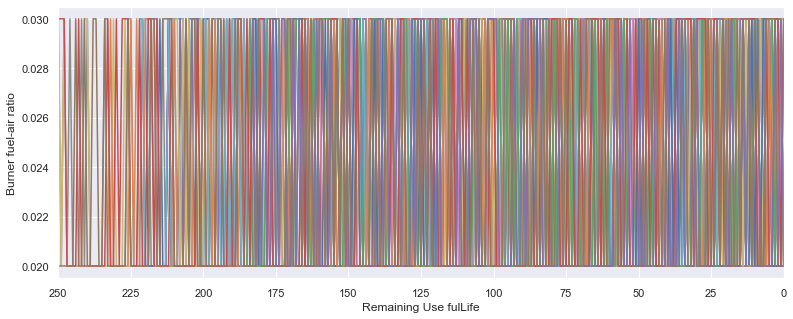

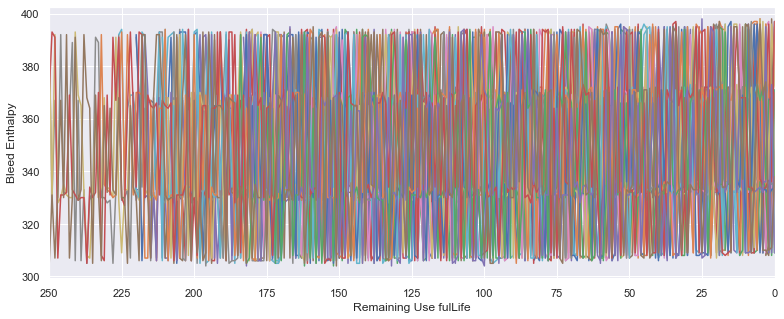

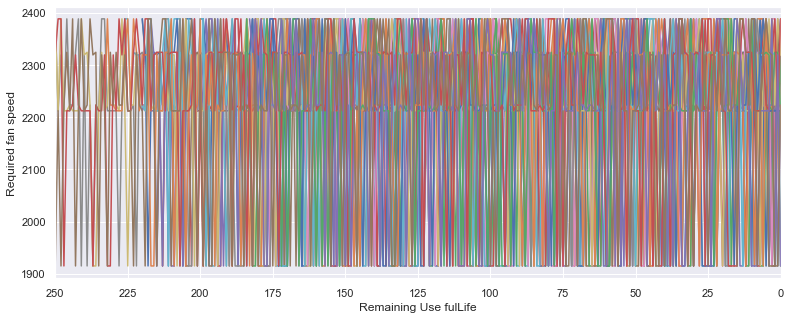

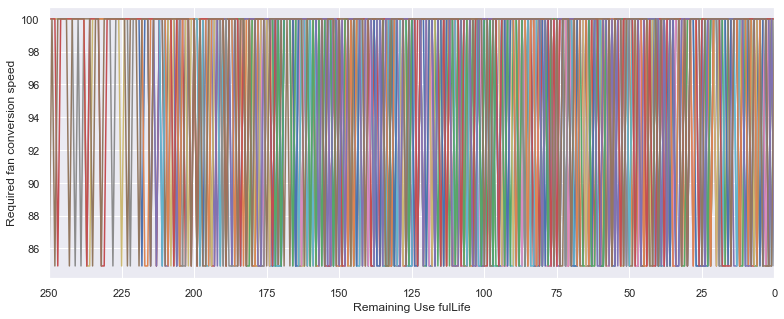

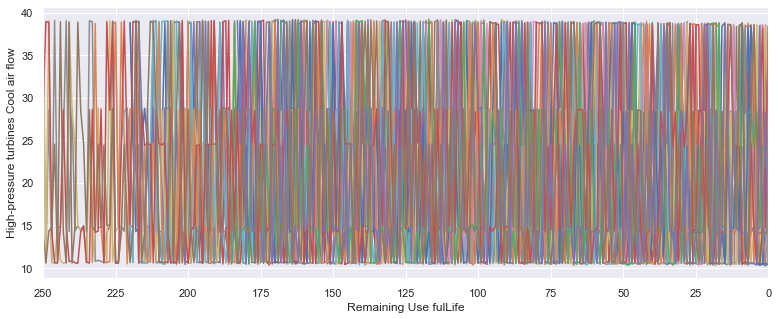

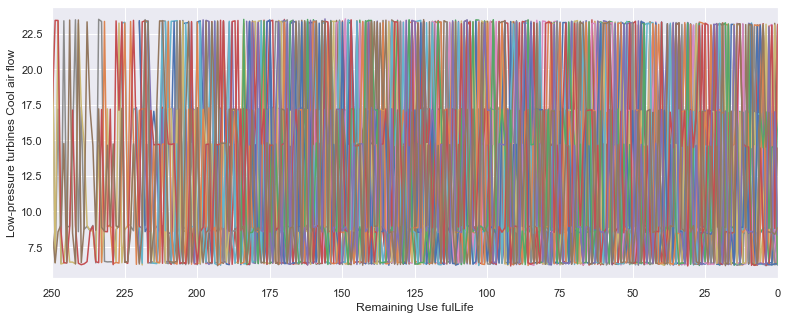

In [18]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

- Based on the plots you can see all sensors hold information related to Remaining Useful Life.
- As on now we will keep all features and will remove non-important features after calculating correlation value of each sensor variable with the RUL.

## Boxplots to find outliers

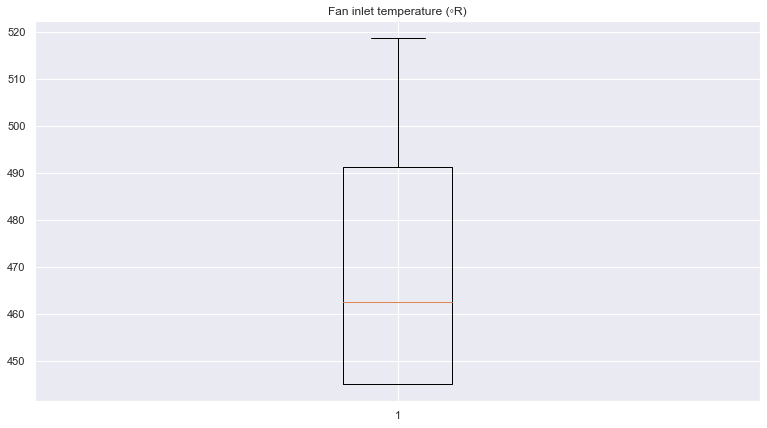

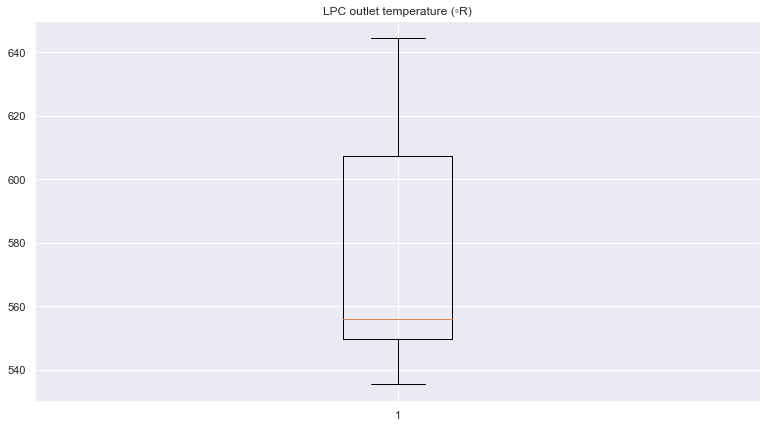

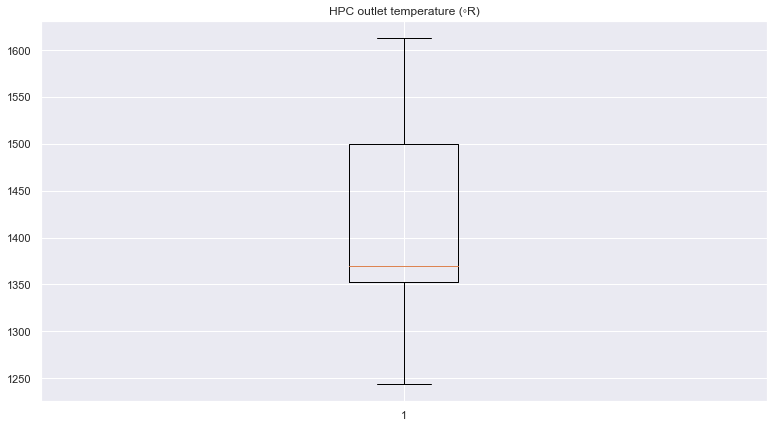

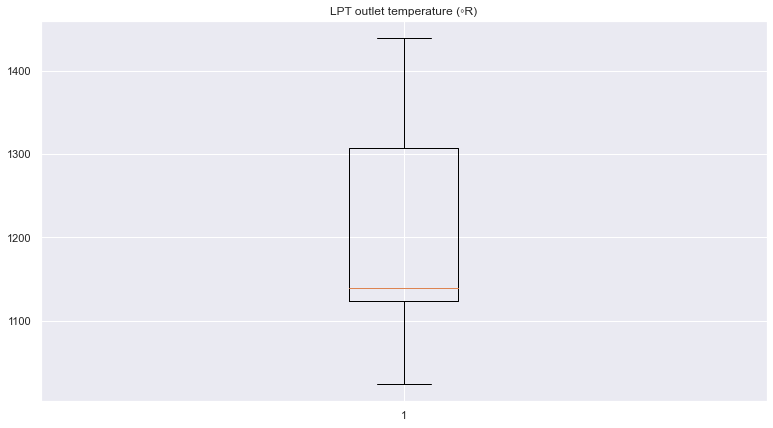

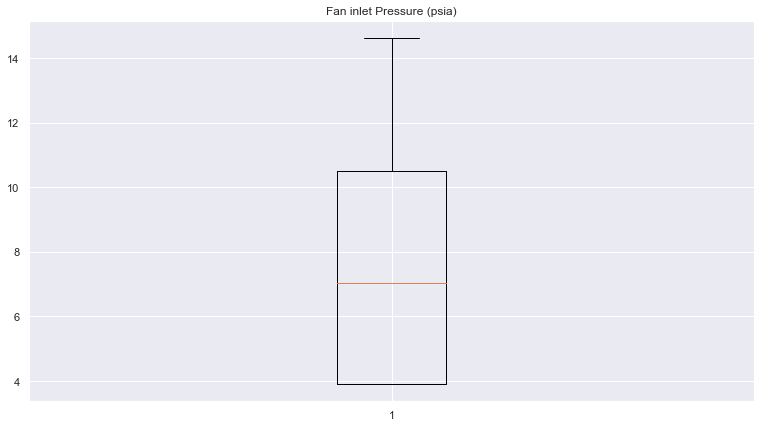

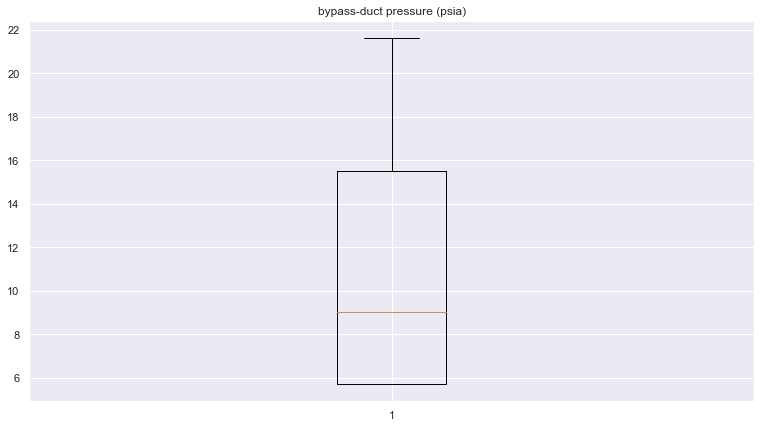

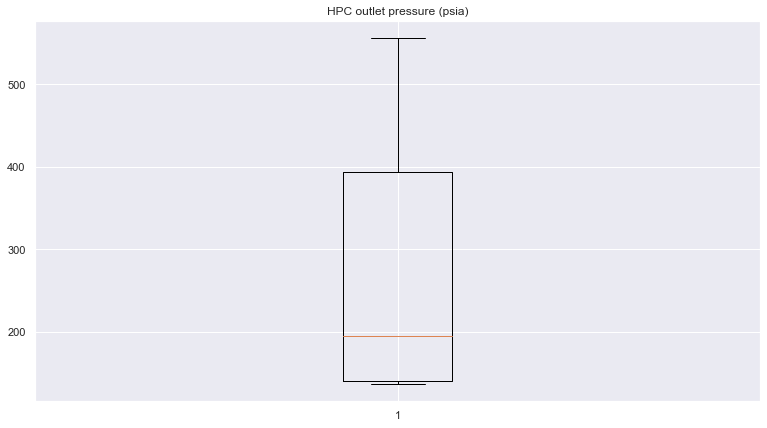

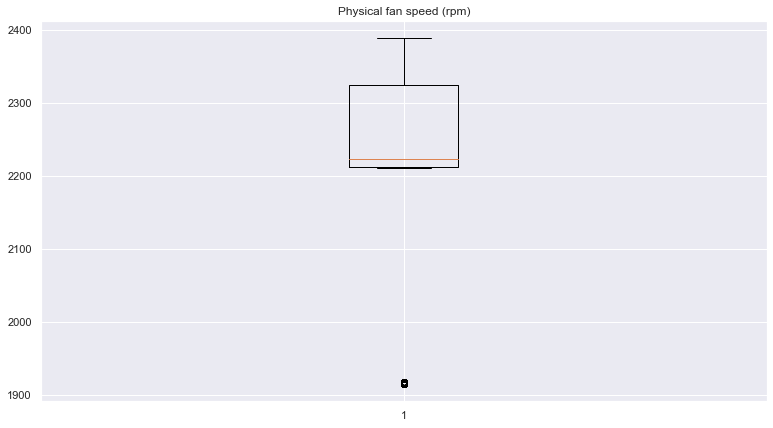

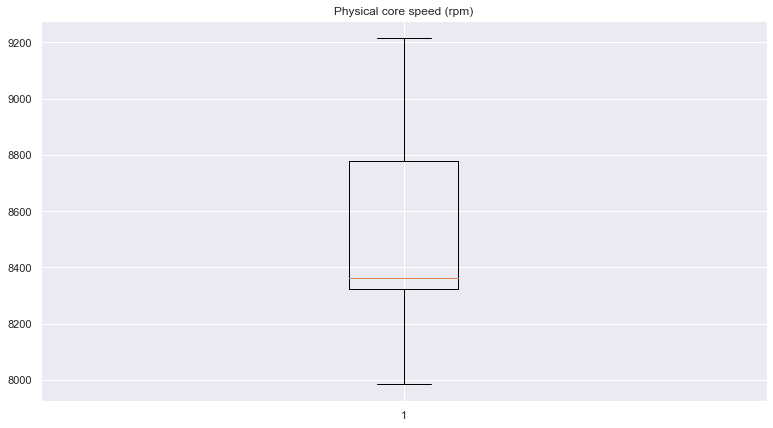

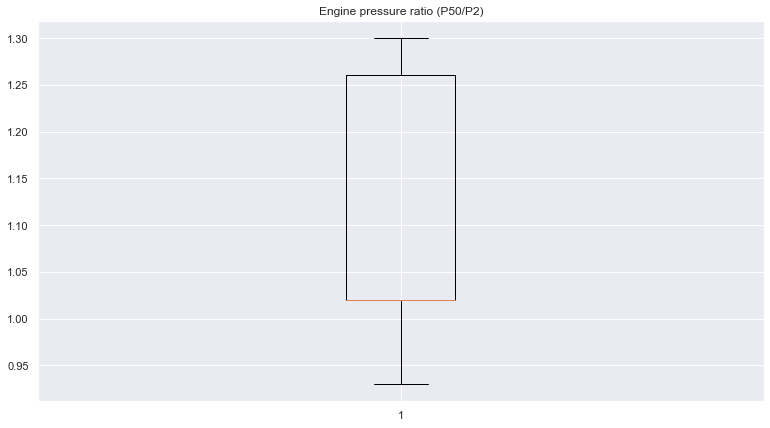

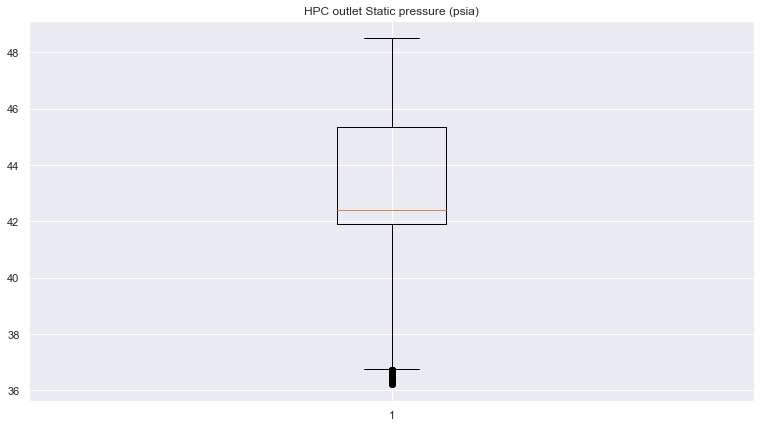

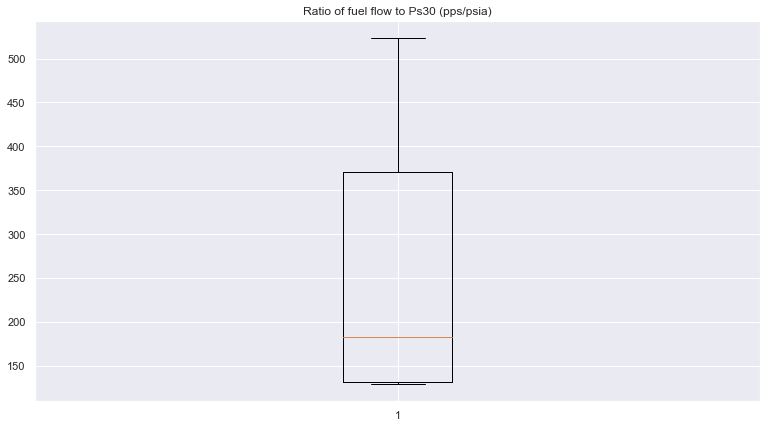

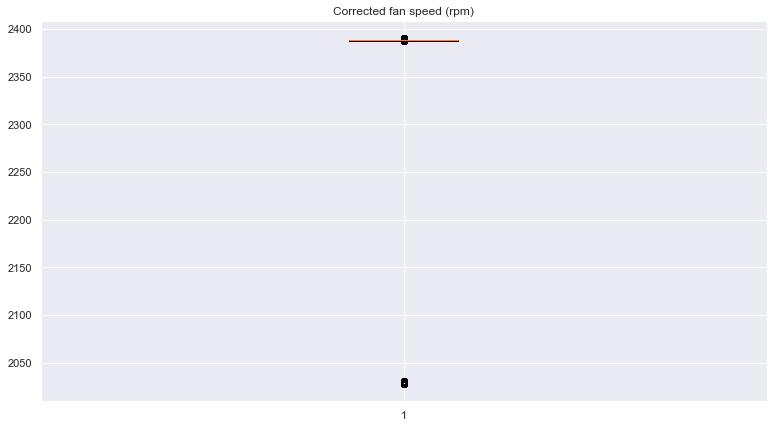

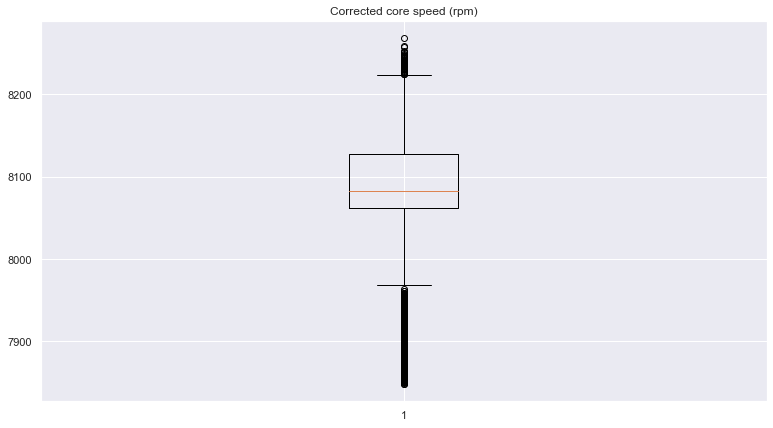

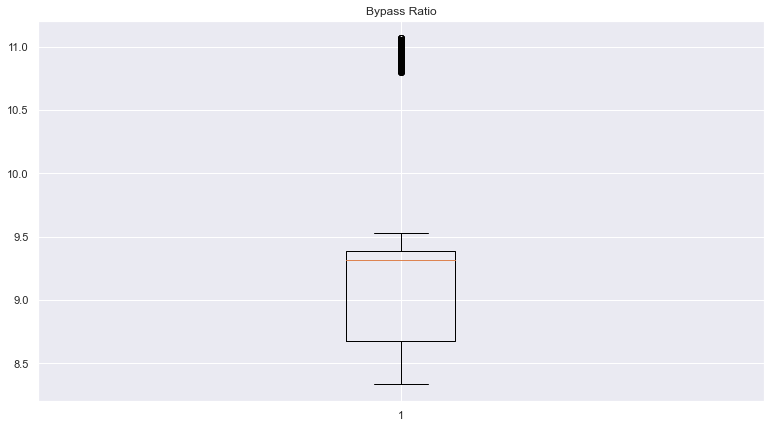

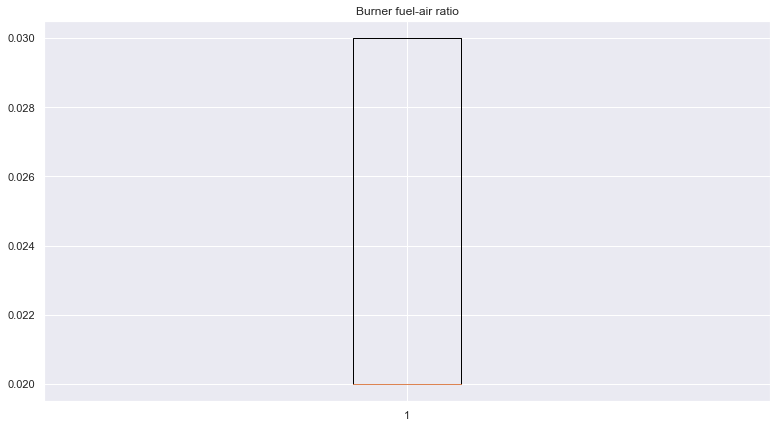

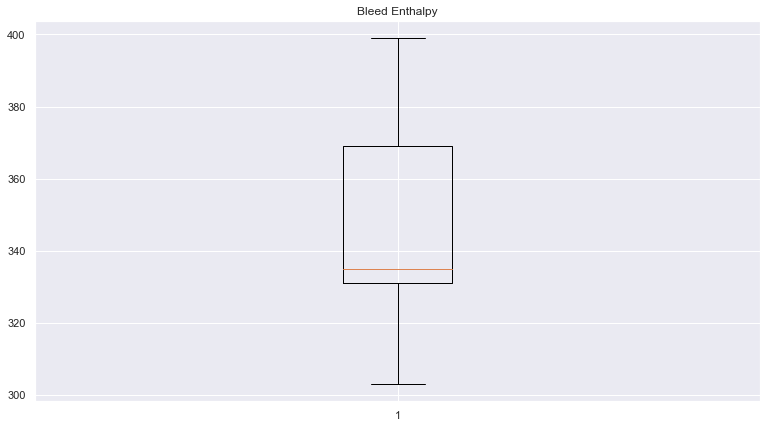

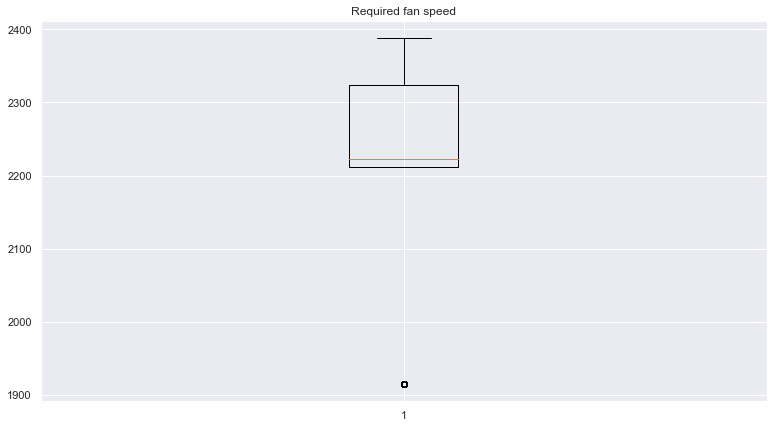

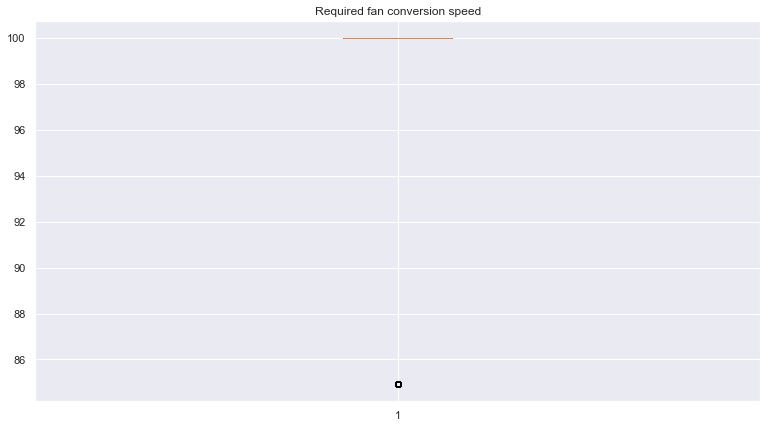

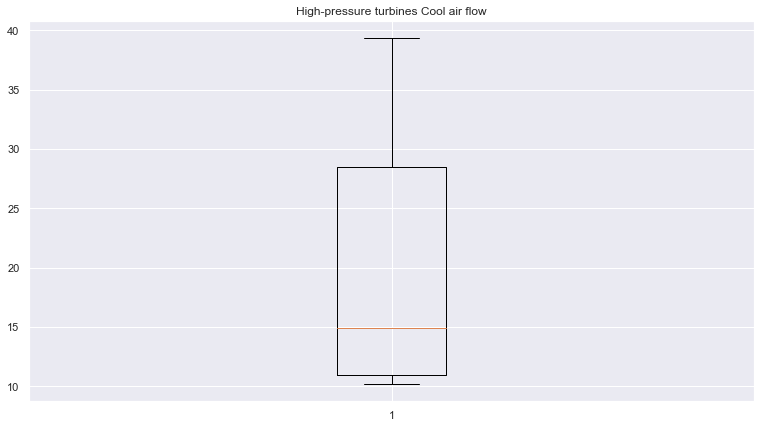

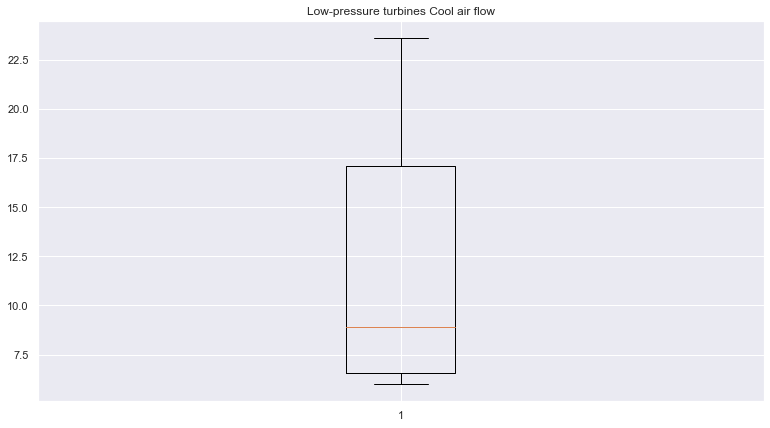

In [19]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

## Max time cycle found for each Unit

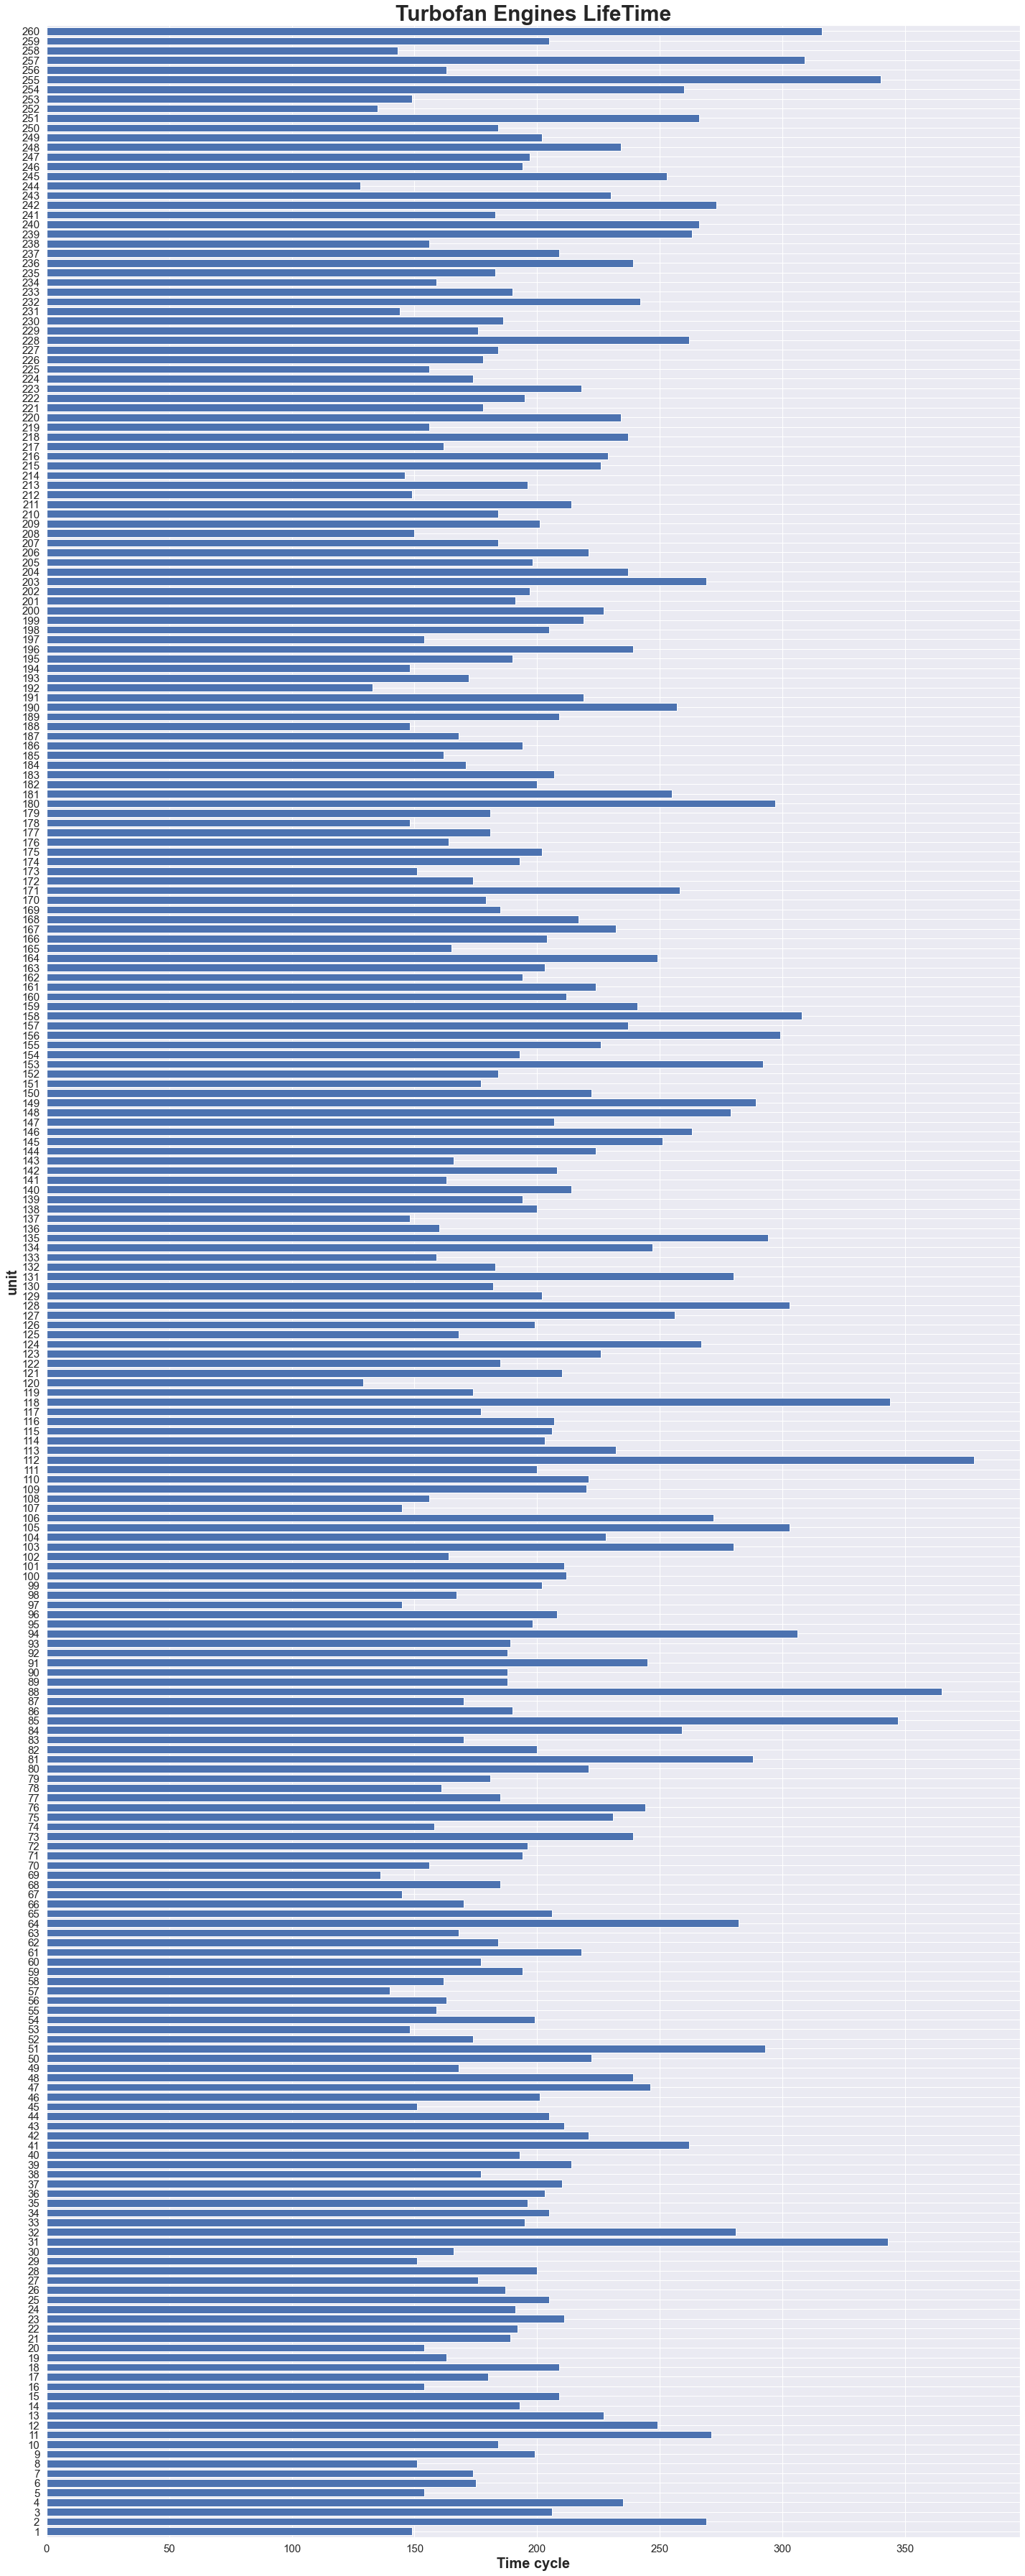

In [20]:
max_time_cycles=train[index_names].groupby('unit_nr').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 8.959999999999994, 'max time cycle')

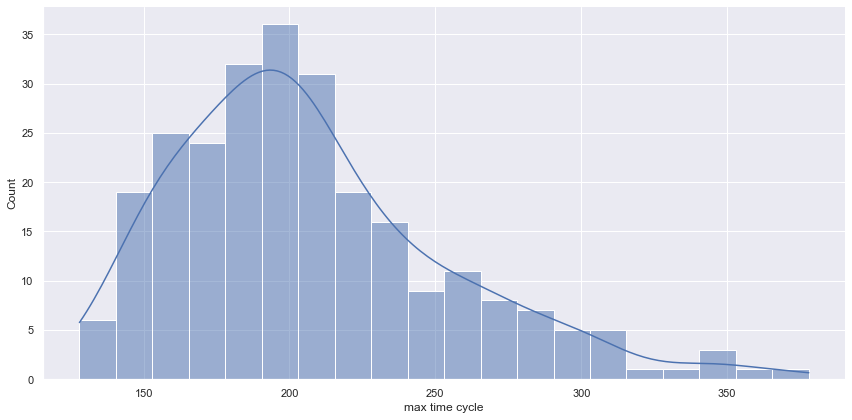

In [21]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

## Extraction of only Important Features which have strong relation affecting RUL of engine

In [22]:
# This is done to select only important features for model building in order to avoid problem of " Overfitting".

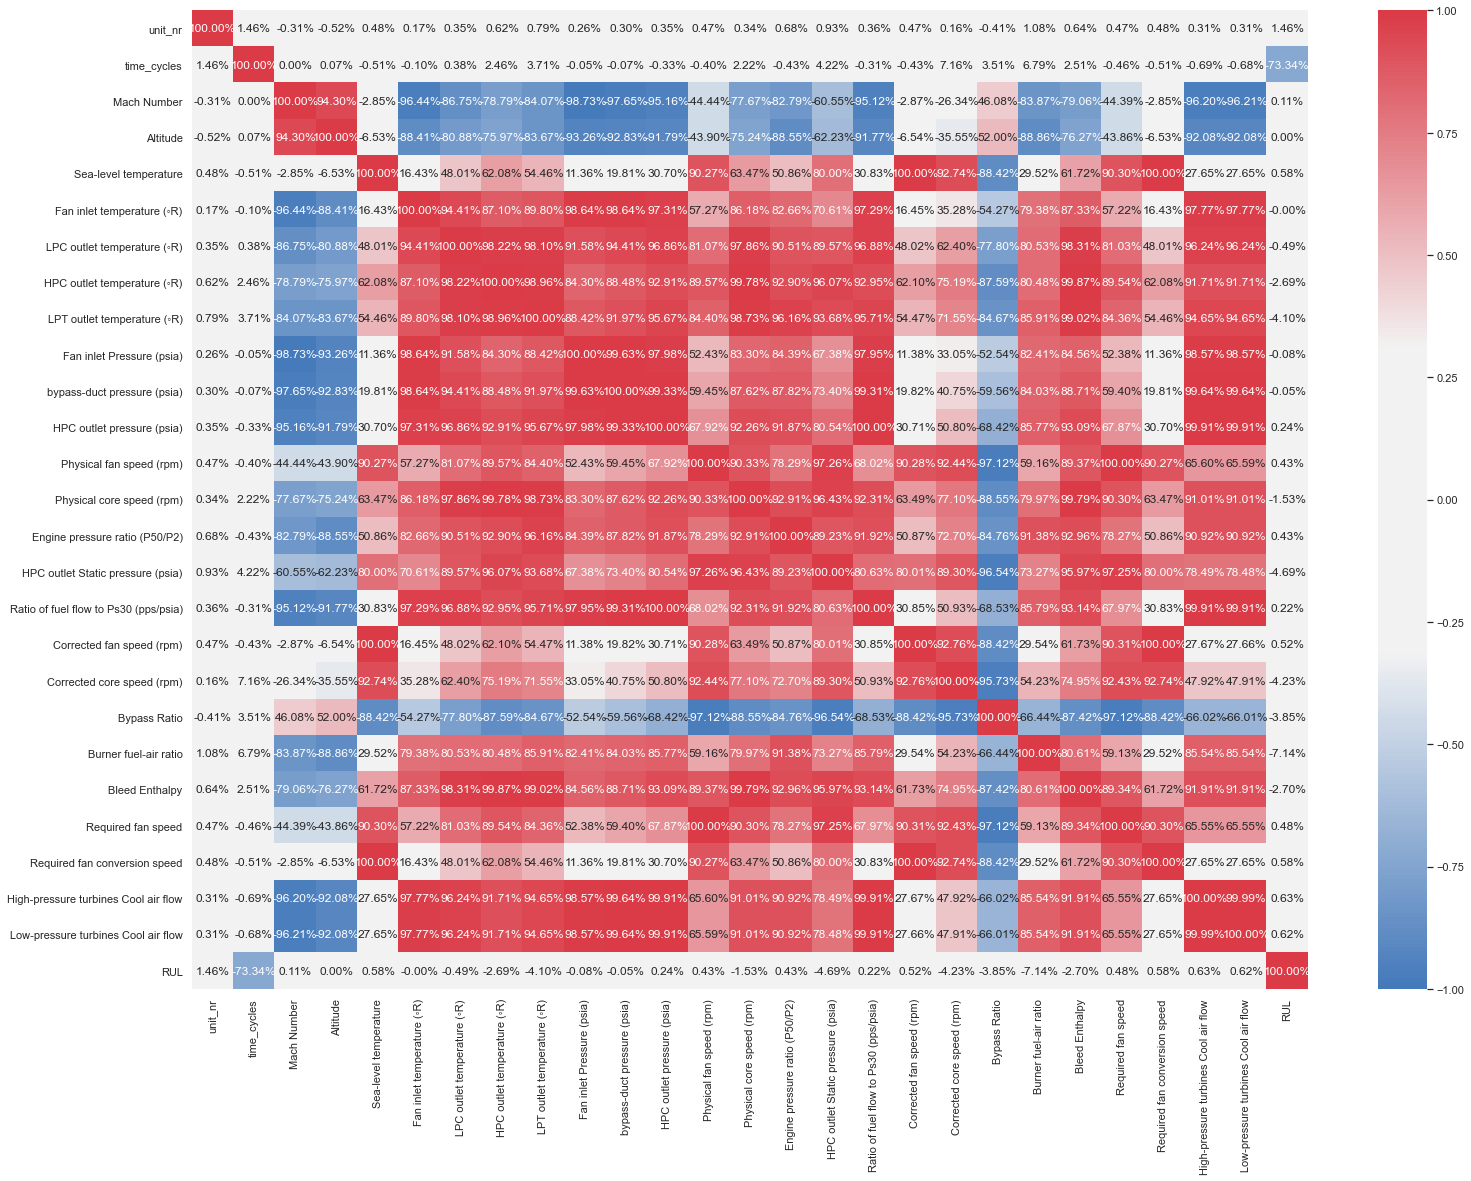

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 18))
correlation_matrix = train.corr()

# Define a custom color map with varying shades
cmap = sns.diverging_palette(250, 10, sep=80, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2%', vmin=-1, vmax=1)
plt.show()


From the above heatmap we can see all the features are correlated with each other

In [24]:
train.head(5)

unit_nr  time_cycles  Mach Number  Altitude  Sea-level temperature  \
0        1            1      34.9983    0.8400                  100.0   
1        1            2      41.9982    0.8408                  100.0   
2        1            3      24.9988    0.6218                   60.0   
3        1            4      42.0077    0.8416                  100.0   
4        1            5      25.0005    0.6203                   60.0   

   Fan inlet temperature (◦R)  LPC outlet temperature (◦R)  \
0                      449.44                       555.32   
1                      445.00                       549.90   
2                      462.54                       537.31   
3                      445.00                       549.51   
4                      462.54                       537.07   

   HPC outlet temperature (◦R)  LPT outlet temperature (◦R)  \
0                      1358.61                      1137.23   
1                      1353.22                      1125.78   
2                      1256.76                      1047.45   
3                      1354.03                      1126.38   
4                      1257.71                      1047.93   

   Fan inlet Pressure (psia)  ...  Corrected fan speed (rpm)  \
0                       5.48  ...                    2387.72   
1                       3.91  ...                    2387.66   
2                       7.05  ...                    2028.03   
3                       3.91  ...                    2387.61   
4                       7.05  ...                    2028.00   

   Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
0                     8048.56        9.3461                   0.02   
1                     8072.30        9.3774                   0.02   
2                     7864.87       10.8941                   0.02   
3                     8068.66        9.3528                   0.02   
4                     7861.23       10.8963                   0.02   

   Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
0             334                2223                         100.00   
1             330                2212                         100.00   
2             309                1915                          84.93   
3             329                2212                         100.00   
4             309                1915                          84.93   

   High-pressure turbines Cool air flow  Low-pressure turbines Cool air flow  \
0                                 14.73                               8.8071   
1                                 10.41                               6.2665   
2                                 14.08                               8.6723   
3                                 10.59                               6.4701   
4                                 14.13                               8.5286   

   RUL  
0  148  
1  147  
2  146  
3  145  
4  144  

[5 rows x 27 columns]

## Seperating Train & Test Data

In [25]:
# train & y_train
# Calculated RUL variable is our Target variable.
y_train=train['RUL']
X_train=train.drop(['unit_nr','time_cycles','RUL'],axis=1)
X_train.head(5)

Mach Number  Altitude  Sea-level temperature  Fan inlet temperature (◦R)  \
0      34.9983    0.8400                  100.0                      449.44   
1      41.9982    0.8408                  100.0                      445.00   
2      24.9988    0.6218                   60.0                      462.54   
3      42.0077    0.8416                  100.0                      445.00   
4      25.0005    0.6203                   60.0                      462.54   

   LPC outlet temperature (◦R)  HPC outlet temperature (◦R)  \
0                       555.32                      1358.61   
1                       549.90                      1353.22   
2                       537.31                      1256.76   
3                       549.51                      1354.03   
4                       537.07                      1257.71   

   LPT outlet temperature (◦R)  Fan inlet Pressure (psia)  \
0                      1137.23                       5.48   
1                      1125.78                       3.91   
2                      1047.45                       7.05   
3                      1126.38                       3.91   
4                      1047.93                       7.05   

   bypass-duct pressure (psia)  HPC outlet pressure (psia)  ...  \
0                         8.00                      194.64  ...   
1                         5.71                      138.51  ...   
2                         9.02                      175.71  ...   
3                         5.71                      138.46  ...   
4                         9.03                      175.05  ...   

   Ratio of fuel flow to Ps30 (pps/psia)  Corrected fan speed (rpm)  \
0                                 183.06                    2387.72   
1                                 130.42                    2387.66   
2                                 164.22                    2028.03   
3                                 130.72                    2387.61   
4                                 164.31                    2028.00   

   Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
0                     8048.56        9.3461                   0.02   
1                     8072.30        9.3774                   0.02   
2                     7864.87       10.8941                   0.02   
3                     8068.66        9.3528                   0.02   
4                     7861.23       10.8963                   0.02   

   Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
0             334                2223                         100.00   
1             330                2212                         100.00   
2             309                1915                          84.93   
3             329                2212                         100.00   
4             309                1915                          84.93   

   High-pressure turbines Cool air flow  Low-pressure turbines Cool air flow  
0                                 14.73                               8.8071  
1                                 10.41                               6.2665  
2                                 14.08                               8.6723  
3                                 10.59                               6.4701  
4                                 14.13                               8.5286  

[5 rows x 24 columns]

In [26]:
test.head(5)

Mach Number  Altitude  Sea-level temperature  Fan inlet temperature (◦R)  \
0      10.0076    0.2501                  100.0                      489.05   
1       0.0018    0.0000                  100.0                      518.67   
2      35.0015    0.8412                  100.0                      449.44   
3      20.0032    0.7000                  100.0                      491.19   
4      42.0055    0.8400                  100.0                      445.00   

   LPC outlet temperature (◦R)  HPC outlet temperature (◦R)  \
0                       605.42                      1515.00   
1                       642.67                      1591.67   
2                       555.86                      1370.62   
3                       607.99                      1487.94   
4                       550.81                      1358.95   

   LPT outlet temperature (◦R)  Fan inlet Pressure (psia)  \
0                      1325.07                      10.52   
1                      1418.17                      14.62   
2                      1135.59                       5.48   
3                      1257.49                       9.35   
4                      1140.34                       3.91   

   bypass-duct pressure (psia)  HPC outlet pressure (psia)  ...  \
0                        15.50                      393.58  ...   
1                        21.61                      553.36  ...   
2                         8.00                      194.58  ...   
3                        13.66                      334.39  ...   
4                         5.72                      138.42  ...   

   Ratio of fuel flow to Ps30 (pps/psia)  Corrected fan speed (rpm)  \
0                                 370.87                    2388.32   
1                                 521.10                    2388.12   
2                                 183.11                    2388.07   
3                                 314.88                    2388.12   
4                                 130.82                    2389.06   

   Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
0                     8167.06        8.7456                   0.03   
1                     8138.12        8.4248                   0.03   
2                     8071.23        9.3094                   0.02   
3                     8062.39        9.2349                   0.02   
4                     8140.94        9.3964                   0.02   

   Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
0             371                2319                          100.0   
1             393                2388                          100.0   
2             332                2223                          100.0   
3             365                2324                          100.0   
4             333                2212                          100.0   

   High-pressure turbines Cool air flow  Low-pressure turbines Cool air flow  
0                                 28.30                              17.0934  
1                                 38.82                              23.3463  
2                                 14.75                               8.9589  
3                                 24.22                              14.6814  
4                                 10.34                               6.3601  

[5 rows x 24 columns]

In [27]:
# Check the columns in X_train
print(X_train.columns)

# Test data set, keeping only train columns/features.
X_test = test[X_train.columns]
X_test.head(5)


Index(['Mach Number', 'Altitude', 'Sea-level temperature',
       'Fan inlet temperature (◦R)', 'LPC outlet temperature (◦R)',
       'HPC outlet temperature (◦R)', 'LPT outlet temperature (◦R)',
       'Fan inlet Pressure (psia)', 'bypass-duct pressure (psia)',
       'HPC outlet pressure (psia)', 'Physical fan speed (rpm)',
       'Physical core speed (rpm)', 'Engine pressure ratio (P50/P2)',
       'HPC outlet Static pressure (psia)',
       'Ratio of fuel flow to Ps30 (pps/psia)', 'Corrected fan speed (rpm)',
       'Corrected core speed (rpm)', 'Bypass Ratio', 'Burner fuel-air ratio',
       'Bleed Enthalpy', 'Required fan speed', 'Required fan conversion speed',
       'High-pressure turbines Cool air flow',
       'Low-pressure turbines Cool air flow'],
      dtype='object')


Mach Number  Altitude  Sea-level temperature  Fan inlet temperature (◦R)  \
0      10.0076    0.2501                  100.0                      489.05   
1       0.0018    0.0000                  100.0                      518.67   
2      35.0015    0.8412                  100.0                      449.44   
3      20.0032    0.7000                  100.0                      491.19   
4      42.0055    0.8400                  100.0                      445.00   

   LPC outlet temperature (◦R)  HPC outlet temperature (◦R)  \
0                       605.42                      1515.00   
1                       642.67                      1591.67   
2                       555.86                      1370.62   
3                       607.99                      1487.94   
4                       550.81                      1358.95   

   LPT outlet temperature (◦R)  Fan inlet Pressure (psia)  \
0                      1325.07                      10.52   
1                      1418.17                      14.62   
2                      1135.59                       5.48   
3                      1257.49                       9.35   
4                      1140.34                       3.91   

   bypass-duct pressure (psia)  HPC outlet pressure (psia)  ...  \
0                        15.50                      393.58  ...   
1                        21.61                      553.36  ...   
2                         8.00                      194.58  ...   
3                        13.66                      334.39  ...   
4                         5.72                      138.42  ...   

   Ratio of fuel flow to Ps30 (pps/psia)  Corrected fan speed (rpm)  \
0                                 370.87                    2388.32   
1                                 521.10                    2388.12   
2                                 183.11                    2388.07   
3                                 314.88                    2388.12   
4                                 130.82                    2389.06   

   Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
0                     8167.06        8.7456                   0.03   
1                     8138.12        8.4248                   0.03   
2                     8071.23        9.3094                   0.02   
3                     8062.39        9.2349                   0.02   
4                     8140.94        9.3964                   0.02   

   Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
0             371                2319                          100.0   
1             393                2388                          100.0   
2             332                2223                          100.0   
3             365                2324                          100.0   
4             333                2212                          100.0   

   High-pressure turbines Cool air flow  Low-pressure turbines Cool air flow  
0                                 28.30                              17.0934  
1                                 38.82                              23.3463  
2                                 14.75                               8.9589  
3                                 24.22                              14.6814  
4                                 10.34                               6.3601  

[5 rows x 24 columns]

In [28]:
y_test.head(5)

RUL
0   18
1   79
2  106
3  110
4   15

In [29]:
y_train.describe()

count    53759.000000
mean       108.154746
std         69.180569
min          0.000000
25%         51.000000
50%        103.000000
75%        156.000000
max        377.000000
Name: RUL, dtype: float64

In [30]:
# Clipping of RUL at 103 , RUL is left skewed.
# This is done to improve performance of the applied models.

y_train= y_train.clip(upper=103)
y_train.head(5)

0    103
1    103
2    103
3    103
4    103
Name: RUL, dtype: int64

In [31]:
y_test.describe()

RUL
count  259.000000
mean    81.185328
std     53.882916
min      6.000000
25%     35.000000
50%     80.000000
75%    121.000000
max    194.000000

In [32]:
y_test= y_test.clip(upper=103)
y_test.head(5)

RUL
0   18
1   79
2  103
3  103
4   15

## Building Model

In [33]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance;

## Bi-LSTM model

In [34]:
# Model: Bidirectional LSTM
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [35]:
# Preprocess data for LSTM
scaler_lstm = StandardScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

In [36]:
# Reshape input for LSTM (assuming your data is sequential)
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))


In [37]:
# Build and train the Bidirectional LSTM model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
bilstm_model = build_bilstm_model(input_shape)


In [38]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [39]:
# Train the model
bilstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
1344/1344 [==============================] - 6s 3ms/step - loss: 1851.5488 - mae: 35.5898 - val_loss: 959.2747 - val_mae: 26.9551
Epoch 2/50
1344/1344 [==============================] - 4s 3ms/step - loss: 787.3667 - mae: 24.2260 - val_loss: 634.6111 - val_mae: 21.3820
Epoch 3/50
1344/1344 [==============================] - 3s 2ms/step - loss: 521.2662 - mae: 18.8014 - val_loss: 440.7291 - val_mae: 17.3190
Epoch 4/50
1344/1344 [==============================] - 3s 2ms/step - loss: 387.9434 - mae: 15.7778 - val_loss: 364.2493 - val_mae: 15.4385
Epoch 5/50
1344/1344 [==============================] - 3s 2ms/step - loss: 334.7455 - mae: 14.5711 - val_loss: 323.6560 - val_mae: 14.3580
Epoch 6/50
1344/1344 [==============================] - 3s 2ms/step - loss: 311.4660 - mae: 14.0369 - val_loss: 309.3487 - val_mae: 14.1264
Epoch 7/50
1344/1344 [==============================] - 3s 2ms/step - loss: 297.4632 - mae: 13.6632 - val_loss: 306.2910 - val_mae: 14.0654
Epoch 8/50
1344/134

In [40]:
# Evaluate on train data
y_hat_train_lstm = bilstm_model.predict(X_train_lstm)
RMSE_Train_LSTM, R2_Train_LSTM = evaluate(y_train, y_hat_train_lstm, 'train')

1680/1680 [==============================] - 3s 1ms/step
train set RMSE:16.09637567421617, R2:0.7679112767818457


In [41]:
# Evaluate on test data
y_hat_test_lstm = bilstm_model.predict(X_test_lstm)
RMSE_Test_LSTM, R2_Test_LSTM = evaluate(y_test, y_hat_test_lstm, 'test')


9/9 [==============================] - 0s 3ms/step
test set RMSE:15.699691335652377, R2:0.8137315821228007


In [42]:
# Make Dataframe which will contain results of all applied Model
Results=pd.DataFrame({'Model': ['BiLSTM'],
    'RMSE-Train': [RMSE_Train_LSTM],
    'R2-Train': [R2_Train_LSTM],
    'RMSE-Test': [RMSE_Test_LSTM],
    'R2-Test': [R2_Test_LSTM]})
Results

Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0  BiLSTM   16.096376  0.767911  15.699691  0.813732

## Bi-TRNN model

In [43]:
# Model: Bidirectional TRNN (replace with your desired function name)
def Bi_trnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [44]:
# Preprocess data for Bi-TRNN
scaler_bi_trnn = StandardScaler()
X_train_bi_trnn = scaler_bi_trnn.fit_transform(X_train)
X_test_bi_trnn = scaler_bi_trnn.transform(X_test)


In [45]:
# Reshape input for Bi-TRNN (assuming your data is sequential)
X_train_bi_trnn = X_train_bi_trnn.reshape((X_train_bi_trnn.shape[0], X_train_bi_trnn.shape[1], 1))
X_test_bi_trnn = X_test_bi_trnn.reshape((X_test_bi_trnn.shape[0], X_test_bi_trnn.shape[1], 1))


In [46]:
# Build and train the Bidirectional TRNN model
input_shape_bi_trnn = (X_train_bi_trnn.shape[1], X_train_bi_trnn.shape[2])
bi_trnn_model = Bi_trnn(input_shape_bi_trnn)
# Define early stopping to prevent overfitting
early_stopping_bi_trnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [47]:
# Train the model
bi_trnn_model.fit(X_train_bi_trnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_trnn])


Epoch 1/50
1344/1344 [==============================] - 11s 6ms/step - loss: 1223.5046 - mae: 29.3509 - val_loss: 734.5887 - val_mae: 19.2438
Epoch 2/50
1344/1344 [==============================] - 8s 6ms/step - loss: 524.5580 - mae: 17.7184 - val_loss: 538.1467 - val_mae: 19.6932
Epoch 3/50
1344/1344 [==============================] - 8s 6ms/step - loss: 421.6073 - mae: 15.5698 - val_loss: 378.6306 - val_mae: 14.4756
Epoch 4/50
1344/1344 [==============================] - 8s 6ms/step - loss: 381.6779 - mae: 14.7788 - val_loss: 355.2693 - val_mae: 13.6705
Epoch 5/50
1344/1344 [==============================] - 8s 6ms/step - loss: 358.6561 - mae: 14.3348 - val_loss: 363.0223 - val_mae: 15.0053
Epoch 6/50
1344/1344 [==============================] - 8s 6ms/step - loss: 351.2713 - mae: 14.1448 - val_loss: 371.1335 - val_mae: 15.0032
Epoch 7/50
1344/1344 [==============================] - 8s 6ms/step - loss: 340.2390 - mae: 13.8732 - val_loss: 341.4555 - val_mae: 14.5464
Epoch 8/50
1344/13

In [48]:
# Evaluate on train data
y_hat_train_bi_trnn = bi_trnn_model.predict(X_train_bi_trnn)
RMSE_Train_BiTRNN, R2_Train_BiTRNN = evaluate(y_train, y_hat_train_bi_trnn, 'train')


1680/1680 [==============================] - 4s 2ms/step
train set RMSE:15.701271027089524, R2:0.7791652261719475


In [49]:
# Evaluate on test data
y_hat_test_bi_trnn = bi_trnn_model.predict(X_test_bi_trnn)
RMSE_Test_BiTRNN, R2_Test_BiTRNN = evaluate(y_test, y_hat_test_bi_trnn, 'test')


9/9 [==============================] - 0s 2ms/step
test set RMSE:14.672945059279543, R2:0.8372984911444609


In [50]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiTRNN'],
    'RMSE-Train': [RMSE_Train_BiTRNN],
    'R2-Train': [R2_Train_BiTRNN],
    'RMSE-Test': [RMSE_Test_BiTRNN],
    'R2-Test': [R2_Test_BiTRNN]
}), ignore_index=True)

# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0  BiLSTM   16.096376  0.767911  15.699691  0.813732
1  BiTRNN   15.701271  0.779165  14.672945  0.837298

## Bi-GRU model

In [51]:
# Model: Bidirectional GRU (Bi-GRU)
def build_bi_gru_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [52]:
# Preprocess data for GRU
scaler_bi_gru = StandardScaler()
X_train_bi_gru = scaler_bi_gru.fit_transform(X_train)
X_test_bi_gru = scaler_bi_gru.transform(X_test)


In [53]:
# Reshape input for GRU 
X_train_bi_gru = X_train_bi_gru.reshape((X_train_bi_gru.shape[0], 1, X_train_bi_gru.shape[1]))
X_test_bi_gru = X_test_bi_gru.reshape((X_test_bi_gru.shape[0], 1, X_test_bi_gru.shape[1]))


In [54]:
# Build and train the Bidirectional GRU model
input_shape_bi_gru = (X_train_bi_gru.shape[1], X_train_bi_gru.shape[2])
bi_gru_model = build_bi_gru_model(input_shape_bi_gru)


In [55]:
# Define early stopping to prevent overfitting
early_stopping_bi_gru = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [56]:
# Train the model
bi_gru_model.fit(X_train_bi_gru, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_gru])


Epoch 1/50
1344/1344 [==============================] - 6s 3ms/step - loss: 1799.0948 - mae: 35.1237 - val_loss: 969.4219 - val_mae: 27.3264
Epoch 2/50
1344/1344 [==============================] - 3s 2ms/step - loss: 779.3306 - mae: 24.0426 - val_loss: 633.8143 - val_mae: 20.8863
Epoch 3/50
1344/1344 [==============================] - 3s 2ms/step - loss: 511.0818 - mae: 18.5802 - val_loss: 429.5690 - val_mae: 16.3002
Epoch 4/50
1344/1344 [==============================] - 3s 2ms/step - loss: 370.2717 - mae: 15.2644 - val_loss: 353.7942 - val_mae: 14.8450
Epoch 5/50
1344/1344 [==============================] - 3s 2ms/step - loss: 317.2106 - mae: 14.0737 - val_loss: 323.7099 - val_mae: 14.3296
Epoch 6/50
1344/1344 [==============================] - 3s 2ms/step - loss: 297.9826 - mae: 13.6518 - val_loss: 303.9260 - val_mae: 13.9372
Epoch 7/50
1344/1344 [==============================] - 3s 2ms/step - loss: 289.6106 - mae: 13.4643 - val_loss: 290.1576 - val_mae: 13.4195
Epoch 8/50
1344/134

In [57]:
# Evaluate on train data
y_hat_train_bi_gru = bi_gru_model.predict(X_train_bi_gru)
RMSE_Train_BiGRU, R2_Train_BiGRU = evaluate(y_train, y_hat_train_bi_gru, 'train')


1680/1680 [==============================] - 2s 1ms/step
train set RMSE:16.2648167253276, R2:0.763028461459885


In [58]:
# Evaluate on test data
y_hat_test_bi_gru = bi_gru_model.predict(X_test_bi_gru)
RMSE_Test_BiGRU, R2_Test_BiGRU = evaluate(y_test, y_hat_test_bi_gru, 'test')


9/9 [==============================] - 0s 2ms/step
test set RMSE:16.42875546483201, R2:0.7960299847069098


In [59]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiGRU'],
    'RMSE-Train': [RMSE_Train_BiGRU],
    'R2-Train': [R2_Train_BiGRU],
    'RMSE-Test': [RMSE_Test_BiGRU],
    'R2-Test': [R2_Test_BiGRU]
}), ignore_index=True)


In [60]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0  BiLSTM   16.096376  0.767911  15.699691  0.813732
1  BiTRNN   15.701271  0.779165  14.672945  0.837298
2   BiGRU   16.264817  0.763028  16.428755  0.796030

## Prognet model

In [61]:
# Model: ProgNet (Progressive Neural Network)
def build_prognet_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [62]:
# Preprocess data for ProgNet
scaler_prognet = StandardScaler()
X_train_prognet = scaler_prognet.fit_transform(X_train)
X_test_prognet = scaler_prognet.transform(X_test)


In [63]:
# Reshape input for LSTM 
X_train_prognet = X_train_prognet.reshape((X_train_prognet.shape[0], X_train_prognet.shape[1], 1))

# Build and train the ProgNet model
input_shape_prognet = (X_train_prognet.shape[1], X_train_prognet.shape[2])
prognet_model = build_prognet_model(input_shape_prognet)


In [64]:
# Define early stopping to prevent overfitting
early_stopping_prognet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [65]:
# Train the model
prognet_model.fit(X_train_prognet, y_train, epochs=70, batch_size=32, validation_split=0.2, callbacks=[early_stopping_prognet])


Epoch 1/70
1344/1344 [==============================] - 22s 15ms/step - loss: 1301.9004 - mae: 30.6340 - val_loss: 1122.9423 - val_mae: 28.9508
Epoch 2/70
1344/1344 [==============================] - 21s 15ms/step - loss: 1124.2021 - mae: 29.1287 - val_loss: 1112.0502 - val_mae: 28.5411
Epoch 3/70
1344/1344 [==============================] - 22s 16ms/step - loss: 967.5998 - mae: 26.2565 - val_loss: 693.1077 - val_mae: 22.3405
Epoch 4/70
1344/1344 [==============================] - 23s 17ms/step - loss: 632.3759 - mae: 19.5865 - val_loss: 543.7188 - val_mae: 16.9079
Epoch 5/70
1344/1344 [==============================] - 22s 16ms/step - loss: 530.6235 - mae: 17.5802 - val_loss: 585.4144 - val_mae: 20.2368
Epoch 6/70
1344/1344 [==============================] - 22s 16ms/step - loss: 431.9604 - mae: 15.8123 - val_loss: 386.5360 - val_mae: 15.3295
Epoch 7/70
1344/1344 [==============================] - 23s 17ms/step - loss: 374.0416 - mae: 14.4453 - val_loss: 491.8536 - val_mae: 17.9435
Ep

In [66]:
# Evaluate on train data
y_hat_train_prognet = prognet_model.predict(X_train_prognet)
RMSE_Train_ProgNet, R2_Train_ProgNet = evaluate(y_train, y_hat_train_prognet, 'train')


1680/1680 [==============================] - 11s 6ms/step
train set RMSE:15.46508152446917, R2:0.7857591573647963


In [67]:
# Reshape input for LSTM 
X_test_prognet = X_test_prognet.reshape((X_test_prognet.shape[0], X_test_prognet.shape[1], 1))

# Evaluate on test data
y_hat_test_prognet = prognet_model.predict(X_test_prognet)

# Now you can proceed with the evaluation
RMSE_Test_ProgNet, R2_Test_ProgNet = evaluate(y_test, y_hat_test_prognet, 'test')


9/9 [==============================] - 0s 6ms/step
test set RMSE:14.108987581156802, R2:0.8495650659029227


In [68]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['ProgNet'],
    'RMSE-Train': [RMSE_Train_ProgNet],
    'R2-Train': [R2_Train_ProgNet],
    'RMSE-Test': [RMSE_Test_ProgNet],
    'R2-Test': [R2_Test_ProgNet]
}), ignore_index=True)

In [69]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0   BiLSTM   16.096376  0.767911  15.699691  0.813732
1   BiTRNN   15.701271  0.779165  14.672945  0.837298
2    BiGRU   16.264817  0.763028  16.428755  0.796030
3  ProgNet   15.465082  0.785759  14.108988  0.849565

## DCNN model

In [70]:
# Model: Deep Convolutional Neural Network (DCNN)
def build_dcnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [71]:
# Preprocess data for DCNN
scaler_dcnn = StandardScaler()
X_train_dcnn = scaler_dcnn.fit_transform(X_train)
X_test_dcnn = scaler_dcnn.transform(X_test)

In [72]:
# Reshape input for DCNN 
X_train_dcnn = X_train_dcnn.reshape((X_train_dcnn.shape[0], X_train_dcnn.shape[1], 1))
X_test_dcnn = X_test_dcnn.reshape((X_test_dcnn.shape[0], X_test_dcnn.shape[1], 1))


In [73]:
# Build and train the DCNN model
input_shape_dcnn = (X_train_dcnn.shape[1], X_train_dcnn.shape[2])
dcnn_model = build_dcnn_model(input_shape_dcnn)

In [74]:
# Define early stopping to prevent overfitting
early_stopping_dcnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [75]:
# Train the model
dcnn_model.fit(X_train_dcnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_dcnn])


Epoch 1/50
1344/1344 [==============================] - 6s 3ms/step - loss: 1363.7179 - mae: 31.1759 - val_loss: 1112.2975 - val_mae: 27.7883
Epoch 2/50
1344/1344 [==============================] - 4s 3ms/step - loss: 925.3196 - mae: 25.8849 - val_loss: 737.7609 - val_mae: 21.8305
Epoch 3/50
1344/1344 [==============================] - 4s 3ms/step - loss: 594.0114 - mae: 19.4247 - val_loss: 436.5467 - val_mae: 16.6656
Epoch 4/50
1344/1344 [==============================] - 4s 3ms/step - loss: 372.4362 - mae: 14.9939 - val_loss: 401.2849 - val_mae: 16.4749
Epoch 5/50
1344/1344 [==============================] - 4s 3ms/step - loss: 317.2851 - mae: 13.8519 - val_loss: 400.7723 - val_mae: 15.0734
Epoch 6/50
1344/1344 [==============================] - 4s 3ms/step - loss: 297.7315 - mae: 13.3382 - val_loss: 285.0745 - val_mae: 13.0507
Epoch 7/50
1344/1344 [==============================] - 4s 3ms/step - loss: 284.4445 - mae: 12.9754 - val_loss: 290.9199 - val_mae: 13.5236
Epoch 8/50
1344/13

In [76]:
# Evaluate on train data
y_hat_train_dcnn = dcnn_model.predict(X_train_dcnn)
RMSE_Train_DCNN, R2_Train_DCNN = evaluate(y_train, y_hat_train_dcnn, 'train')


1680/1680 [==============================] - 3s 2ms/step
train set RMSE:14.899383088549891, R2:0.8011459622379737


In [77]:
# Evaluate on test data
y_hat_test_dcnn = dcnn_model.predict(X_test_dcnn)
RMSE_Test_DCNN, R2_Test_DCNN = evaluate(y_test, y_hat_test_dcnn, 'test')


9/9 [==============================] - 0s 2ms/step
test set RMSE:14.178650314164484, R2:0.8480758619152784


In [78]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['DCNN'],
    'RMSE-Train': [RMSE_Train_DCNN],
    'R2-Train': [R2_Train_DCNN],
    'RMSE-Test': [RMSE_Test_DCNN],
    'R2-Test': [R2_Test_DCNN]
}), ignore_index=True)

In [79]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0   BiLSTM   16.096376  0.767911  15.699691  0.813732
1   BiTRNN   15.701271  0.779165  14.672945  0.837298
2    BiGRU   16.264817  0.763028  16.428755  0.796030
3  ProgNet   15.465082  0.785759  14.108988  0.849565
4     DCNN   14.899383  0.801146  14.178650  0.848076

## Individual model result

In [80]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0   BiLSTM   16.096376  0.767911  15.699691  0.813732
1   BiTRNN   15.701271  0.779165  14.672945  0.837298
2    BiGRU   16.264817  0.763028  16.428755  0.796030
3  ProgNet   15.465082  0.785759  14.108988  0.849565
4     DCNN   14.899383  0.801146  14.178650  0.848076

## Ensemble model using Random Forest Regressor

In [81]:
# Concatenate predictions from all the base learners  for training data
X_train_ensemble = np.concatenate((y_hat_train_bi_trnn, y_hat_train_bi_gru, y_hat_train_dcnn, y_hat_train_prognet, y_hat_train_lstm), axis=1)

# Concatenate predictions from all the base learners for test data
X_test_ensemble = np.concatenate((y_hat_test_bi_trnn,y_hat_test_bi_gru,y_hat_test_dcnn, y_hat_test_prognet, y_hat_test_lstm), axis=1)


In [82]:
# Model : Random Forest 
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)


In [83]:
# Train the Random Forest model
random_forest_model.fit(X_train_ensemble, y_train)


RandomForestRegressor(max_depth=10, random_state=42)

In [84]:
# Predictions on training data
y_hat_train_rf = random_forest_model.predict(X_train_ensemble)
RMSE_Train_RF, R2_Train_RF = evaluate(y_train, y_hat_train_rf, 'train')

# Predictions on test data
y_hat_test_rf = random_forest_model.predict(X_test_ensemble)
RMSE_Test_RF, R2_Test_RF = evaluate(y_test, y_hat_test_rf, 'test')


train set RMSE:13.678199515100445, R2:0.8324070641973755
test set RMSE:13.872042997305844, R2:0.8545754092691382


In [85]:
import pandas as pd

# Reshape arrays to have shape (n_samples, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
y_hat_test_rf_reshaped = y_hat_test_rf.reshape(-1, 1)

# Create DataFrame with actual and predicted RUL
df_results = pd.DataFrame({'Actual RUL': y_test_reshaped.flatten(), 'Predicted RUL': y_hat_test_rf_reshaped.flatten()})

# Display the DataFrame
print(df_results)


     Actual RUL  Predicted RUL
0            18      14.538165
1            79      92.153564
2           103      94.390862
3           103      85.947857
4            15      15.892302
5           103     101.875021
6             6      18.489573
7            90      56.096031
8            11       6.380428
9            79      93.158593
10            6       7.829583
11           73      93.434623
12           30      63.666973
13           11      12.407656
14           37      56.372599
15           67      97.662032
16           68      73.799649
17           99     101.918279
18           22      21.198140
19           54      72.451985
20           97      89.380567
21           10      12.919749
22          103      89.693162
23           77      68.651000
24           88      93.250919
25          103     100.087326
26          103     100.281459
27          103      93.207906
28           83      96.549069
29           78      68.580663
30           75     100.152888
31      

In [86]:

# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Random Forest (Ensemble)'],
    'RMSE-Train': [RMSE_Train_RF],
    'R2-Train': [R2_Train_RF],
    'RMSE-Test': [RMSE_Test_RF],
    'R2-Test': [R2_Test_RF]
}), ignore_index=True)

# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0                    BiLSTM   16.096376  0.767911  15.699691  0.813732
1                    BiTRNN   15.701271  0.779165  14.672945  0.837298
2                     BiGRU   16.264817  0.763028  16.428755  0.796030
3                   ProgNet   15.465082  0.785759  14.108988  0.849565
4                      DCNN   14.899383  0.801146  14.178650  0.848076
5  Random Forest (Ensemble)   13.678200  0.832407  13.872043  0.854575

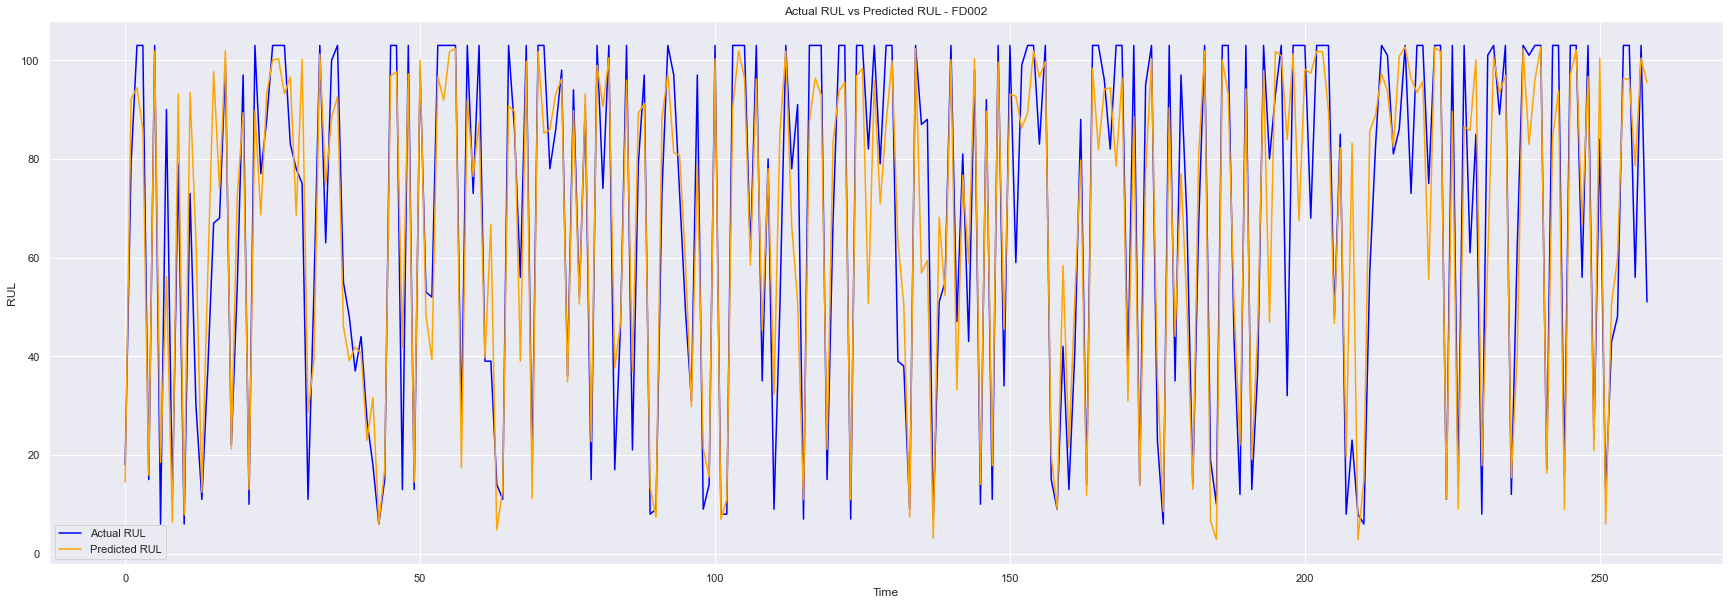

In [87]:

plt.figure(figsize=(30, 10))

# Line chart for actual RUL
plt.plot(y_test, label='Actual RUL', linestyle='-', color='blue')

# Line chart for predicted RUL
plt.plot(y_hat_test_rf, label='Predicted RUL', linestyle='-', color='orange')

plt.title('Actual RUL vs Predicted RUL - FD002')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()


## Conclusion

In [88]:
Results

Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0                    BiLSTM   16.096376  0.767911  15.699691  0.813732
1                    BiTRNN   15.701271  0.779165  14.672945  0.837298
2                     BiGRU   16.264817  0.763028  16.428755  0.796030
3                   ProgNet   15.465082  0.785759  14.108988  0.849565
4                      DCNN   14.899383  0.801146  14.178650  0.848076
5  Random Forest (Ensemble)   13.678200  0.832407  13.872043  0.854575